### Improvements 
## IMP: Fitrar por la surface

1) Remove blinks and interpolate values using cubic splines
2) Blank filtering of data---Done-- maibe explore other filter
3) Frequency analysis of the signal??
4) Remove trials with z scores over [2,-2]
5) Convert time to seconds
6) Open PLA file
7) Statistics of signal ¿How to compare surprise signals?
8) Amplitud, velocidad de cambio
9) Cut the whole signal of interest from the beggining
10) Fitrar por la surface


In [1]:

import pandas as pd 
import numpy as np
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import commons as cm
import sys
sys.path.append('../')
from data_curation import Normalization
nm=Normalization()


recording_location = r"C:\Users\Bolo\Desktop\Laboratorio\incipit\data\pupil_emotibit\ES0001_S002_PC_EM\data\pupil_labs\002"
image_location=r"../../../../data/pupil_emotibit/ES0001_S002_PC_EM/images_order"

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
# print_file_structure(recording_location)


exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)
exported_gaze_csv = os.path.join(recording_location, 'exports', '000', 'gaze_positions.csv')
gaze_pd_frame = pd.read_csv(exported_gaze_csv)
annotations_csv = os.path.join(recording_location, 'exports', '000', 'annotations.csv')
annotations_pd = pd.read_csv(annotations_csv)

### Cut all data by annotations of interest

In [2]:
from IPython.display import display

event_initial=annotations_pd['label'].values[0]
event_final=annotations_pd['label'].values[-1]

initial_anotation,_,_=cm.extract_annotations_timestamps(event_initial,'label',annotations_pd)
end_anotation=annotations_pd.iloc[-1]
display(initial_anotation)
display(end_anotation)

pupil_pd_frame=cm.filter_rows_by_temporal_values(
         dataframe=pupil_pd_frame,
         time_column='pupil_timestamp',
         ini_value=initial_anotation['timestamp'].values[0],
         end_value=end_anotation['timestamp']
         )

,index,timestamp,label,duration
0,5377,15054.349196,blank_0,NaN


index                  34669
timestamp       15545.169033
label        EndOfExperiment
duration                 NaN
Name: 147, dtype: object

## Extract the data
Extracting pupil 3d data for analysis

In [3]:
from IPython.display import display

confidence_thr=1
 
# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == 'pye3d 0.3.0 real-time']

# skip first 5 seconds to allow for the 3D model to converge
# pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]
# pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>0.99), ['diameter','pupil_timestamp']]

pupil_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']>=confidence_thr)]
pupil_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']>=confidence_thr)]
blinks_left_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==1) & (pupil_pd_frame['confidence']< confidence_thr)]
blinks_right_eye=detector_3d_data.loc[(pupil_pd_frame['eye_id']==0) & (pupil_pd_frame['confidence']< confidence_thr)]


filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


# pd.options.display.float_format = '{:.3f}'.format

print("eye0 (right eye) data:")
display(pupil_right_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(pupil_left_eye[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

eye0 (right eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
43421,15054.356030,0,1.0,0.376038,0.496568,3.470677
43425,15054.364049,0,1.0,0.376093,0.496178,3.490731
43429,15054.372089,0,1.0,0.376334,0.496036,3.500846
43432,15054.380040,0,1.0,0.375887,0.496698,3.512908
43436,15054.388039,0,1.0,0.376280,0.496136,3.489541
43440,15054.396023,0,1.0,0.376136,0.496511,3.510092
43444,15054.404063,0,1.0,0.376134,0.496979,3.473783
43449,15054.412031,0,1.0,0.376466,0.497002,3.515241
43453,15054.420031,0,1.0,0.376436,0.496564,3.528533
43459,15054.432050,0,1.0,0.376597,0.496109,3.503948


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
43419,15054.351944,1,1.0,0.345204,0.499847,3.267825
43423,15054.359981,1,1.0,0.344552,0.499894,3.276994
43427,15054.367954,1,1.0,0.344695,0.499790,3.285312
43431,15054.375973,1,1.0,0.344494,0.499855,3.280704
43434,15054.383926,1,1.0,0.344508,0.499846,3.281696
43438,15054.392082,1,1.0,0.344462,0.499776,3.280453
43442,15054.400085,1,1.0,0.344494,0.499852,3.280318
43447,15054.408107,1,1.0,0.344787,0.499655,3.274949
43450,15054.416066,1,1.0,0.344811,0.499833,3.295623
43455,15054.424111,1,1.0,0.344733,0.499816,3.269333


In [4]:
import json
f = open(recording_location+'/info.player.json')
data = json.load(f)
time_whole_recording=data['duration_s']
time_roi_left=abs(pupil_left_eye['pupil_timestamp'].values[-1]-pupil_left_eye['pupil_timestamp'].values[0])
time_roi_right=abs(pupil_right_eye['pupil_timestamp'].values[-1]-pupil_right_eye['pupil_timestamp'].values[0])

pupil_sampling_freq_left=(pupil_left_eye.shape[0]+blinks_left_eye.shape[0])/time_roi_left
pupil_sampling_freq_right=(pupil_right_eye.shape[0]+blinks_right_eye.shape[0])/time_roi_right 
print('sampling frequency for right eye is {}'.format(pupil_sampling_freq_right)) 
print('sampling frequency for left eye is {}'.format(pupil_sampling_freq_left)) 

# Closing file
f.close()


sampling frequency for right eye is 123.93244293739954
sampling frequency for left eye is 123.93043124585135


##  Explore blinks and Asses data quality, are there many regions with data gaps? 


### Asses data quality

In [5]:
total_blinks_left=blinks_left_eye.shape[0]/pupil_sampling_freq_left
total_blinks_right=blinks_right_eye.shape[0]/pupil_sampling_freq_right
print(f'Total blinks time left {total_blinks_left:.2f}s and right {total_blinks_right:.2f}s of a total of {time_roi_left:.2f}s left and {time_roi_right:.2f}s right')
print(f'Total blinks time left {total_blinks_left/time_roi_left:.2%} ')
print(f'Total blinks time right {total_blinks_right/time_roi_right:.2%} ')


Total blinks time left 19.20s and right 58.42s of a total of 490.82s left and 490.81s right
Total blinks time left 3.91% 
Total blinks time right 11.90% 


## Put timestamp data in seconds


In [6]:
pupil_left_eye['timestamp_s']=pupil_left_eye['pupil_timestamp']-pupil_left_eye['pupil_timestamp'].values[0]
pupil_left_eye['timestamp_s']

pupil_right_eye['timestamp_s']=pupil_right_eye['pupil_timestamp']-pupil_right_eye['pupil_timestamp'].values[0]
pupil_right_eye['timestamp_s']

annotations_pd['timestamp_s']=annotations_pd['timestamp']-annotations_pd['timestamp'].values[0]


C:\Users\Bolo\AppData\Local\Temp\ipykernel_13364\2321012662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye['timestamp_s']=pupil_left_eye['pupil_timestamp']-pupil_left_eye['pupil_timestamp'].values[0]
C:\Users\Bolo\AppData\Local\Temp\ipykernel_13364\2321012662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye['timestamp_s']=pupil_right_eye['pupil_timestamp']-pupil_right_eye['pupil_timestamp'].values[0]


### View Raw data

In [7]:
%matplotlib qt
#for left eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_left_eye['pupil_timestamp'],blinks_left_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_left_eye['pupil_timestamp'],pupil_left_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Left eye data')

#for right eye
fig, ax=plt.subplots(1,1)
ax.plot(blinks_right_eye['pupil_timestamp'],blinks_right_eye['diameter_3d'],'.',markersize=1)
ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['blinks','diameter'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Right eye data')

fig, ax=plt.subplots(1,1)

ax.plot(pupil_right_eye['pupil_timestamp'],pupil_right_eye['diameter_3d'],'.',markersize=1)
ax.legend(['left eye','right eye'])    
fig.set_size_inches((9.5, 5.5))
ax.set_title('Both eyes')



Text(0.5, 1.0, 'Both eyes')

### Do cubic splines aeasily, in the future use a better blink detection algorithm

In [8]:


pupil_left_eye['diameter_3d_cubic']=cm.cubic_siplne_interpolation(x=pupil_left_eye['pupil_timestamp'],
                                                y= pupil_left_eye['diameter_3d'])

pupil_right_eye['diameter_3d_cubic']=cm.cubic_siplne_interpolation(x=pupil_right_eye['pupil_timestamp'],
                                                 y= pupil_right_eye['diameter_3d'])

fig, ax = plt.subplots(2,1,figsize=(15, 8))
ax[0].plot(pupil_left_eye['pupil_timestamp'], pupil_left_eye['diameter_3d'], 'o', label='data')
ax[0].plot(pupil_left_eye['pupil_timestamp'], pupil_left_eye['diameter_3d_cubic'],'-', label="interpolated")
ax[0].legend(loc='lower right', ncol=2)
ax[0].set_title('left eye')
ax[0].set_xlabel('sample')
ax[0].set_ylabel('diameter (mm)')


ax[1].plot(pupil_right_eye['pupil_timestamp'], pupil_right_eye['diameter_3d'], 'o', label='data')
ax[1].plot(pupil_right_eye['pupil_timestamp'], pupil_right_eye['diameter_3d_cubic'],'-', label="interpolated")
ax[1].legend(loc='lower right', ncol=2)
ax[1].set_title('right eye')
ax[1].set_xlabel('sample')
ax[1].set_ylabel('diameter (mm)')
fig.tight_layout()

C:\Users\Bolo\AppData\Local\Temp\ipykernel_13364\1115834506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye['diameter_3d_cubic']=cm.cubic_siplne_interpolation(x=pupil_left_eye['pupil_timestamp'],
C:\Users\Bolo\AppData\Local\Temp\ipykernel_13364\1115834506.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye['diameter_3d_cubic']=cm.cubic_siplne_interpolation(x=pupil_right_eye['pupil_timestamp'],


usaing smooting splines

In [9]:
# # %matplotlib qt
# s_cal=np.mean(y)-np.sqrt(np.mean(y)*2)
# s_cal
# from scipy import interpolate
# tck = interpolate.splrep(x, y, s=s_cal)
# ynew = interpolate.splev(xs, tck, der=0)
# fig, ax = plt.subplots(figsize=(6.5, 4))
# ax.plot(x, y, 'o', label='data')
# ax.plot(xs, ynew,'-', label="S")
# ax.legend(loc='lower left', ncol=2)
# plt.show()

## 

In [10]:
time_col_str='timestamp_s'
signal_str='diameter_3d'

%matplotlib qt
sns.set_theme()
fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye[time_col_str],pupil_left_eye[signal_str],'.')
for  index, row in annotations_pd[filter_events].iterrows():
    plt.axvline(row[time_col_str], color='r', label='axvline - full height')
    ax.text((row[time_col_str]),30,row['label'])
ax.set_title('pupil diameter and events')    
ax.set_xlabel(f'{time_col_str}')
ax.set_ylabel(f'{signal_str}')

fig, ax=plt.subplots(1,1)
ax.plot(pupil_left_eye[time_col_str],pupil_left_eye[signal_str],'.')
for  index, row in annotations_pd[filter_events_surprise].iterrows():
    plt.axvline(row[time_col_str], color='r', label='axvline - full height')
    ax.text((row[time_col_str]),30,row['label'])
ax.set_title('pupil diameter and events')    
ax.set_xlabel(f'{time_col_str}')
ax.set_ylabel(f'{signal_str}')

plt.tight_layout()

C:\Users\Bolo\AppData\Local\Temp\ipykernel_13364\924197905.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


## Apply normalizations


### z-score normalization

In [11]:
pupil_left_eye['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_left_eye['diameter_3d_cubic'],
                                            type='z_score')

pupil_right_eye['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_right_eye['diameter_3d_cubic'],
                                            type='z_score')


C:\Users\Bolo\AppData\Local\Temp\ipykernel_13364\3071621190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_left_eye['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_left_eye['diameter_3d_cubic'],
C:\Users\Bolo\AppData\Local\Temp\ipykernel_13364\3071621190.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pupil_right_eye['diameter_3d_cubic_z_score']=nm.normalize(values=pupil_right_eye['diameter_3d_cubic'],


### Filters

In [12]:
filter_events=annotations_pd['label'].str.contains('Asset') | annotations_pd['label'].str.contains('Control') | annotations_pd['label'].str.contains('Surprise')
filter_assets=annotations_pd['label'].str.contains('Asset') 

filter_events_surprise= annotations_pd['label'].str.contains('Surprise')
filter_events_blank= annotations_pd['label'].str.contains('blank')


### Asset normalization

In [21]:
#common variables
pupil_df=pupil_left_eye
signal_str='diameter_3d'

# pupil_df['speed']=abs(pupil_df['diameter_3d'].diff(periods=100).rolling(3).median())

secons_norm=0.4
frames_norm=np.round(secons_norm*pupil_sampling_freq_left).astype(int)
win_norm=range(frames_norm)
print('Initial frames used for normalization = {} correspond to {}s'.format(frames_norm,secons_norm))

window_s=3
window_frames=np.round(window_s*pupil_sampling_freq_left).astype(int)
print('Windows frames of interest   = {} correspond to {}s'.format(window_frames,window_s))
window=range(0,window_frames)
time_x=np.linspace(0,window_s,window_frames)



Initial frames used for normalization = 50 correspond to 0.4s
Windows frames of interest   = 372 correspond to 3s


In [22]:
# For Assets
event=annotations_pd.loc[filter_assets,['label']]
pupil_events_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_events_matrix[0:len(segmented_df),num]=(segmented_df[signal_str]-win_blank[signal_str].mean())


In [23]:
# For Surpriwe

event=annotations_pd.loc[filter_events_surprise,['label']]
pupil_surprise_matrix=np.zeros([pupil_df.shape[0],len(event)])

for num,im in enumerate(event.values.flatten()):
    initial_anotation,end_anotation,index_annotation=cm.extract_annotations_timestamps(im,'label',annotations_pd)
   
    segmented_df=cm.filter_rows_by_temporal_values(
        dataframe=pupil_df,
        time_column='pupil_timestamp',
        ini_value=initial_anotation['timestamp'].values[0],
        end_value=end_anotation['timestamp'].values[0]
        )

    win_blank=segmented_df.iloc[win_norm]

    pupil_surprise_matrix[0:len(segmented_df),num]=(segmented_df[signal_str]-win_blank[signal_str].mean())

### Do the plots

Text(0, 0.5, 'speed (s)')

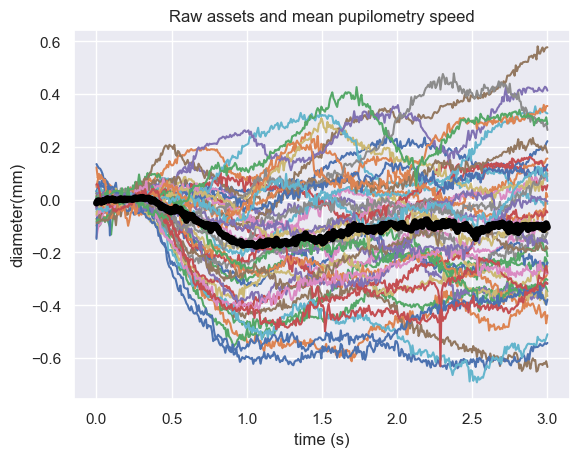

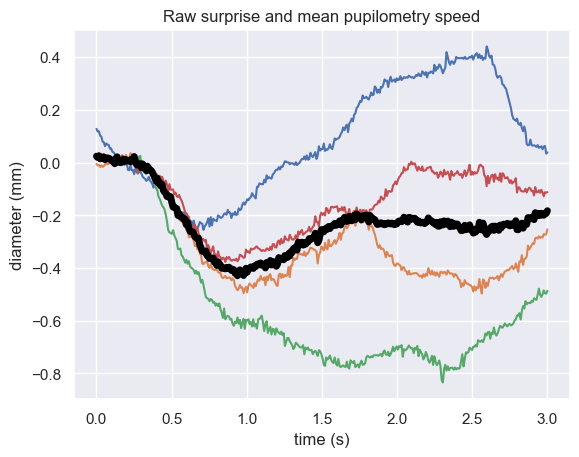

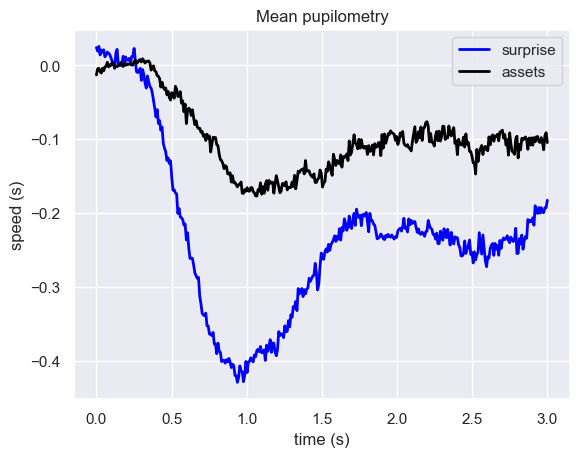

In [24]:
%matplotlib inline


mat=pupil_events_matrix
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat[window])
ax.plot(time_x,np.median(mat[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')


mat=pupil_surprise_matrix
fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat[window,:])
ax.plot(time_x,np.median(mat[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(time_x,np.median(pupil_surprise_matrix[window,:],axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.median(pupil_events_matrix[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

## Now lets calculate the speed of change from the normalized data

In [173]:

pupil_events_speed=np.abs(np.diff(pupil_events_matrix))
pupil_surprise_speed=np.abs(np.diff(pupil_surprise_matrix))

Text(0, 0.5, 'speed (s)')

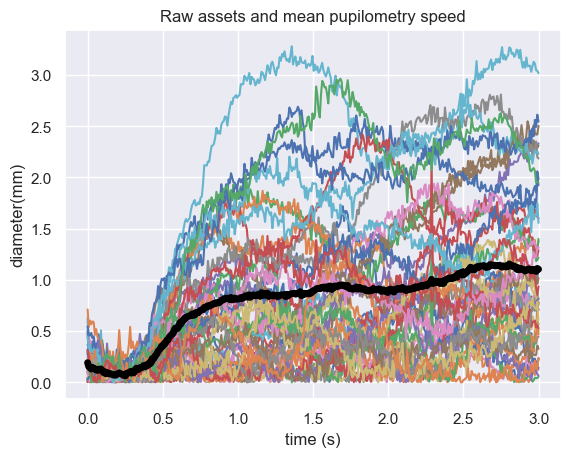

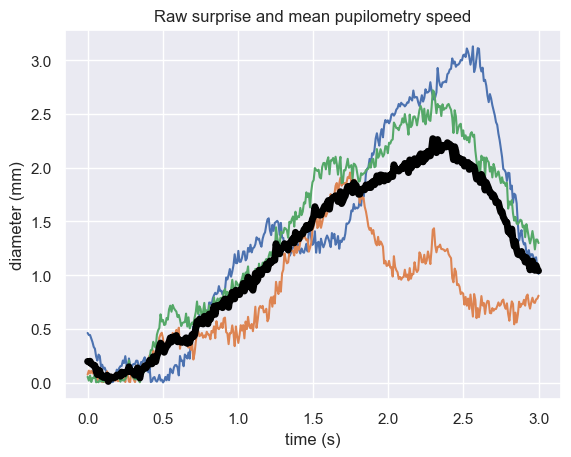

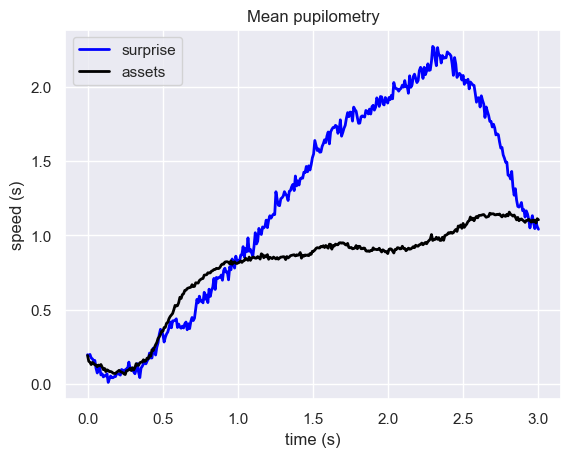

In [174]:
%matplotlib inline

mat1=pupil_events_speed
mat2=pupil_surprise_speed

fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat1[window])
ax.plot(time_x,np.mean(mat1[window,:],axis=1),linewidth=5,color='black')
# ax.legend([images,'assets mean'])
ax.set_title('Raw assets and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter(mm)')

fig, ax=plt.subplots(1,1)
ax.plot(time_x,mat2[window,:])
ax.plot(time_x,np.mean(mat2[window,:],axis=1),linewidth=5,color='black')
ax.set_title('Raw surprise and mean pupilometry speed')
ax.set_xlabel('time (s)')
ax.set_ylabel('diameter (mm)')


fig, ax=plt.subplots(1,1)
ax.plot(time_x,np.mean(mat2[window,:],axis=1),linewidth=2,color='blue')
ax.plot(time_x,np.mean(mat1[window,:],axis=1),linewidth=2,color='black')

ax.legend(['surprise','assets'])
ax.set_title('Mean pupilometry')
ax.set_xlabel('time (s)')
ax.set_ylabel('speed (s)')

Exclude data that is over [2,-2] z scores


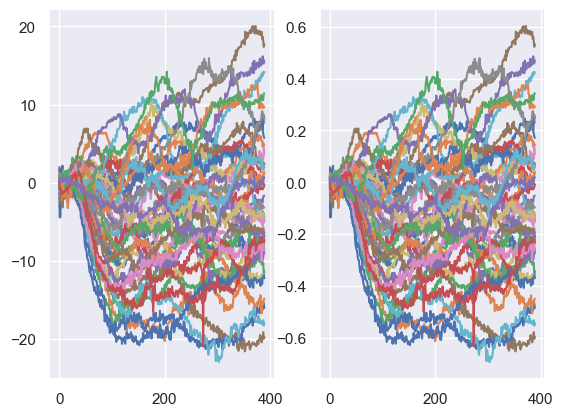

In [135]:
pupil_zscore=nm.normalize(values=pupil_events_matrix.reshape(pupil_events_matrix.size),
                                            type='z_score').reshape(pupil_events_matrix.shape)

fig, ax=plt.subplots(1,2)
ax[0].plot(pupil_zscore[window,:])
ax[1].plot(pupil_events_matrix[window,:])


<AxesSubplot: ylabel='Count'>

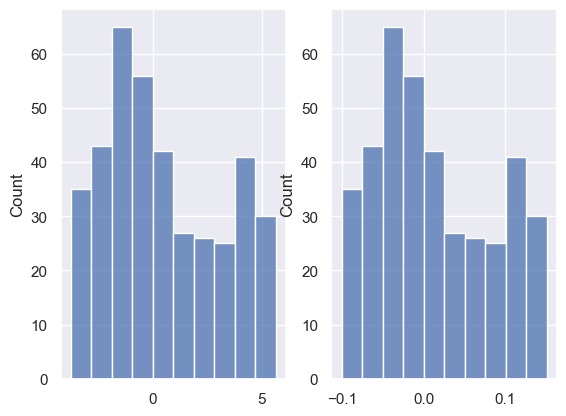

In [ ]:
fig,ax=plt.subplots(1,2)
sns.histplot(pupil_zscore[window,6],ax=ax[0])
sns.histplot(pupil_events_matrix[window,6],ax=ax[1])

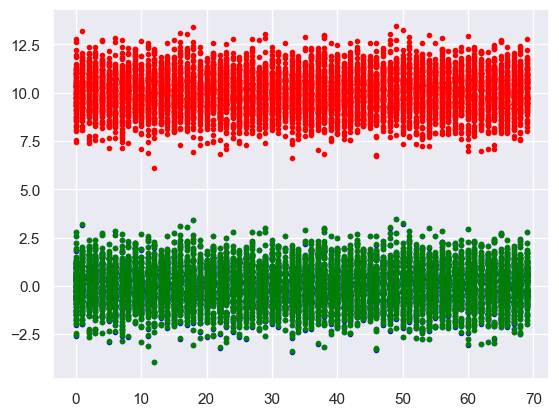

In [ ]:
#test sfuntion
sigma=1
mu=10
data_normal=sigma*np.random.randn(70,100) +mu
data_norm=nm.normalize(values=data_normal.reshape(data_normal.size),
                                            type='z_score').reshape(data_normal.shape)
plt.plot(data_normal,'.',color='red')
plt.plot(data_norm,'.',color='blue')
plt.plot(data_normal-10,'.',color='green')


(array([[ 0.,  0.,  1., 12., 16., 19., 14.,  7.,  1.,  0.],
        [ 0.,  0.,  3., 10., 16., 16., 13., 10.,  1.,  1.],
        [ 0.,  2.,  2., 11., 16., 16., 16.,  3.,  3.,  1.],
        [ 0.,  0.,  3.,  8., 18., 18., 18.,  4.,  1.,  0.],
        [ 0.,  0.,  3., 14., 15., 21., 12.,  4.,  1.,  0.],
        [ 0.,  1.,  6.,  4., 15., 13., 17., 13.,  1.,  0.],
        [ 0.,  0.,  1.,  8., 20., 17., 17.,  4.,  1.,  2.],
        [ 0.,  2.,  2.,  4., 17., 26., 14.,  5.,  0.,  0.],
        [ 0.,  0.,  1.,  3., 14., 23., 21.,  6.,  2.,  0.],
        [ 0.,  1.,  1., 12., 15., 15., 18.,  8.,  0.,  0.],
        [ 0.,  0.,  7.,  8., 20., 22.,  9.,  4.,  0.,  0.],
        [ 0.,  0.,  1., 11., 22., 14., 14.,  7.,  0.,  1.],
        [ 0.,  0.,  1.,  6., 21., 18., 18.,  4.,  2.,  0.],
        [ 0.,  0.,  4.,  6., 11., 22., 14., 10.,  3.,  0.],
        [ 0.,  0.,  3.,  6., 20., 19., 14.,  3.,  5.,  0.],
        [ 0.,  1.,  4.,  6., 12., 29., 10.,  7.,  1.,  0.],
        [ 0.,  0.,  4.,  7., 19., 15., 1

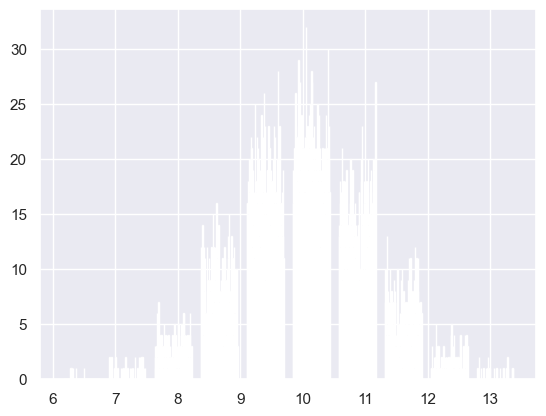

In [ ]:
plt.hist(data_normal)


In [ ]:
pupil_events_matrix.shape[0]

74182

In [ ]:
r=a.reshape(pupil_events_matrix.shape)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
pupil_events_matrix.shape[0]*pupil_events_matrix.shape[1]

3029625

In [ ]:
pupil_events_matrix.shape

(67325, 45)